# Initial Data Filter and QC

In [32]:
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Pasted here is the code that was initially ran. As mentioned in the report, our dataset is large (~31GB combined tables) and couldn't all be ran on a single computer. For the sake of this analysis, we have filtered the data down to a mangageable size (~1.5GB). Additionally, we saw initially that our dataset contained only 6% churn. In order to help improve our model, we wanted to have a filtered dataset that contained a 50/50 split between churn and not churn. 

The methodology to get this data into a useable format was the following:
    - Upload data into google cloud storage
    - Utilize Google BigQuery to run SQL statement against the datasets
    - Export the datasets as CSV files to be managed locally
    
For our dataset we wanted to have approximately 100k members (total dataset size is ~993k members so approximately 10% of our data). Utilizing a 50/50 split we therefore wantedk 50k members who did churn and 50k members who didn't churn. In order to filter the tables we first ran a query to get 50k members who did churn in the labels table:

    SELECT * FROM [w207_kkbox_bq_data.labels] WHERE (RAND(5) < 50000/(SELECT COUNT(*) FROM [w207_kkbox_bq_data.labels] WHERE is_churn = 0) AND is_churn = 0)
    SELECT * FROM [w207_kkbox_bq_data.labels] WHERE (RAND(5) < 50000/(SELECT COUNT(*) FROM [w207_kkbox_bq_data.labels] WHERE is_churn = 0) AND is_churn = 1)
    
These two tables were written to cloud storage and provided the baseline of the members that we would keep when querying other tables. The labels table contains member ID as well as the is_churn (dependent) variable. We now utilize these two tables to query the other datasets joining on the members ID [we kept these two tables separate and then combined the is_churn = 0 and is_churn = 1 into a combined table at the end, in hindsight it would have been more efficient to combine the labels table first]. 

Members Table:

    SELECT members.*  FROM [w207_kkbox_bq_data.members] as members INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_1] as lab ON members.msno = lab.msno
    SELECT members.*  FROM [w207_kkbox_bq_data.members] as members INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_0] as lab ON members.msno = lab.msno

Transactions Table:

    SELECT transactions.*  FROM [w207_kkbox_bq_data.transactions] as transactions INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_0] as lab ON transactions.msno = lab.msno
    SELECT transactions.*  FROM [w207_kkbox_bq_data.transactions] as transactions INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_1] as lab ON transactions.msno = lab.msno
    
User_Logs Table:

        SELECT user_logs.*  FROM [w207_kkbox_bq_data.user_logs] as user_logs INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_1] as lab ON user_logs.msno = lab.msno
        SELECT user_logs.*  FROM [w207_kkbox_bq_data.user_logs] as user_logs INNER JOIN [w207_kkbox_bq_data.labels_filtered_50k_churn_0] as lab ON user_logs.msno = lab.msno
        
With this methodology there was two tables (is_churn = 0 and is_churn = 1) for each table in the original dataset. We then combined/appended the two tables back into a singular table and exported to csv (labels_filtered.csv, members_filtered.csv, transactions_filtered.csv, user_logs_filtered.csv). From these local files we then began development towards predcting churn. 

While we moved ahead with this filtered dataset, we also wanted to perform quick EDA on the entire dataset to the filtered dataset, to compare and contrast some of the features in the dataset. We understand that we artificially inflated the is_churn = 1 statistic for purposes of model training, therefore there will be some changes between the filtered and original dataset. 

In [33]:
%%bq query --name is_churn_large
SELECT SUM(is_churn) / COUNT(is_churn)
FROM `w207_kkbox_bq_data.labels` AS labels

In [34]:
is_churn_large.execute().result()

f0_
0.06392287077349786


In [35]:
%%bq query --name is_churn_small
SELECT SUM(is_churn) / COUNT(is_churn)
FROM `w207_kkbox_bq_data.labels_filtered_100k` AS labels

In [36]:
is_churn_small.execute().result()

f0_
0.5005559729526672


Here we look at the proportion of is_churn data. We can see that we manipulated the churn percentage in the filtered dataset. This was intentional in order to create an approximate even split between is churn and is_not_churn to benefit the model training and increase the number of examples of is_churn (since our original dataset only contains 6% is_churn). 

In [37]:
%%bq query --name cities
SELECT city, COUNT(msno) AS population
FROM `w207_kkbox_bq_data.members` 
GROUP BY city

In [38]:
cities.execute().result()

city,population
1,4804326
5,385069
9,47639
6,135200
4,246848
13,320978
22,210407
14,89940
8,45975
15,190213


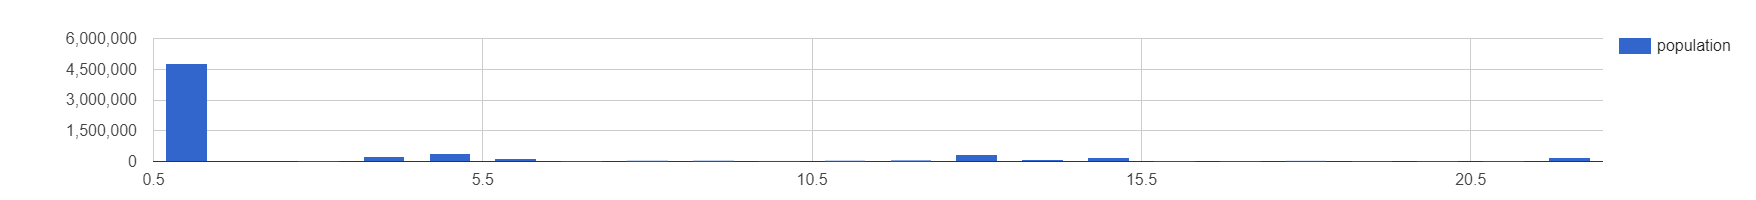

In [39]:
%chart columns --data cities --fields city,population

In [40]:
%%bq query --name cities
SELECT members_city AS city, COUNT(members_msno) AS population
FROM `w207_kkbox_bq_data.members_filtered_100k` 
GROUP BY city

In [41]:
cities.execute().result()

city,population
1,40639
10,763
4,5670
5,8469
13,11012
14,2273
15,5032
8,937
12,1395
22,4825


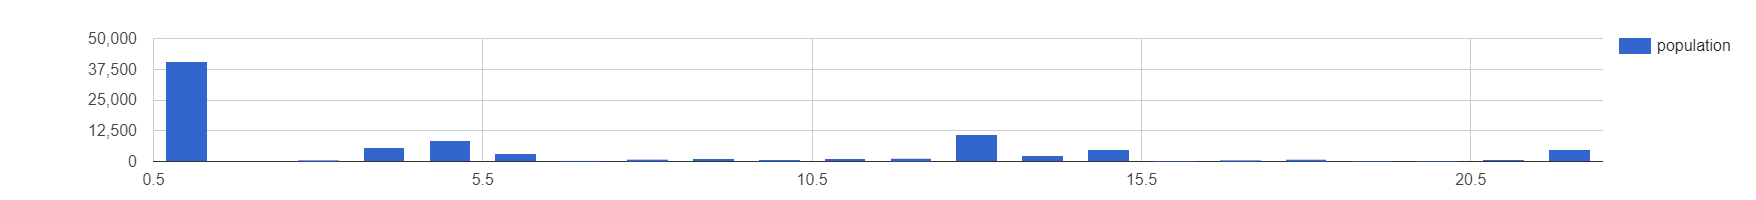

In [42]:
%chart columns --data cities --fields city,population

We can see that there is one city (labeled city = 1 that uses kkbox service far more than any other city accross the geographical area that kkbox is used. Comparing the two datasets, we see that overall city one has a higher proportion of the total members in the original dataset compared to the filtered. 

In [43]:
%%bq query --name city_renew
SELECT members.city AS city, CAST(SUM(transactions.is_auto_renew) / COUNT(members.city) AS FLOAT64) AS renew_by_city
FROM `w207_kkbox_bq_data.members` AS members
INNER JOIN `w207_kkbox_bq_data.transactions` AS transactions
ON members.msno = transactions.msno
GROUP BY members.city
ORDER BY renew_by_city DESC

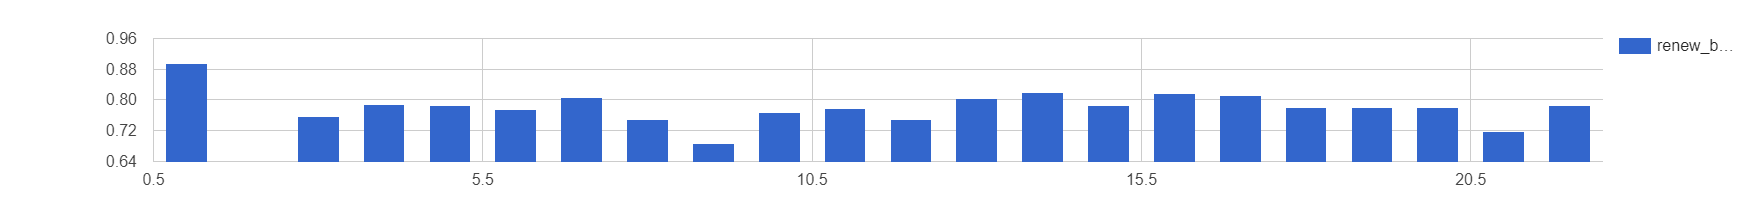

In [44]:
%chart columns --data city_renew --fields city,renew_by_city

In [45]:
%%bq query --name city_renew
SELECT members.members_city AS city, CAST(SUM(transactions.transactions_is_auto_renew) / COUNT(members.members_city) AS FLOAT64) AS renew_by_city
FROM `w207_kkbox_bq_data.members_filtered_100k` AS members
INNER JOIN `w207_kkbox_bq_data.transactions_filtered_100k` AS transactions
ON members.members_msno = transactions.transactions_msno
GROUP BY city
ORDER BY renew_by_city DESC

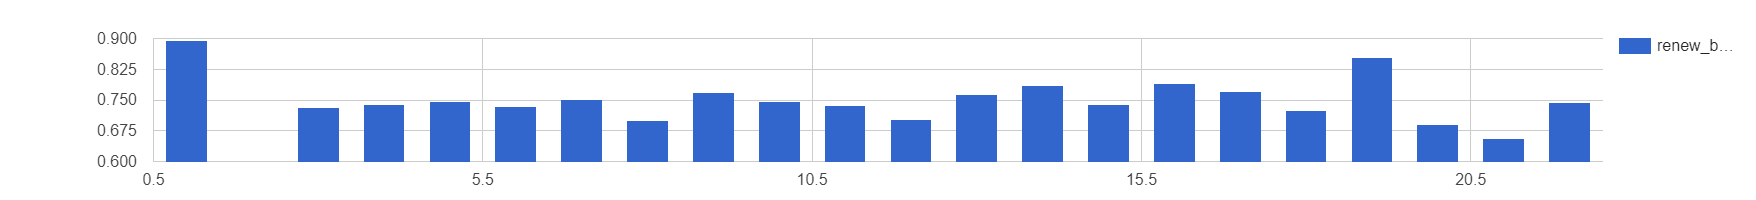

In [46]:
%chart columns --data city_renew --fields city,renew_by_city

In the plot above we analyze the proportion of auto-renew customers by city. From before we saw that city 1 had the highest count overall for users. Here we can see that it also has the highest proportion of auto-renew customers. Overall, it appears that most customers are on an auto-renew plan which is good from a business perspective.

Comparing the two dataframes there is similar structure to both bar charts, which means the datasets for this feature are consistent. 

In [51]:
%%bq query --name gender_describe
SELECT COUNT(gender) AS gen FROM `w207_kkbox_bq_data.members` AS members GROUP BY gender

In [52]:
gender_describe.execute().result()

gen
1144613
1195355
0


In [53]:
%%bq query --name gender_describe
SELECT COUNT(members_gender) AS gen FROM `w207_kkbox_bq_data.members_filtered_100k` AS members GROUP BY members_gender

In [54]:
gender_describe.execute().result()

gen
24507
21630
0


From the printout above, we can see that there is similarity amongst the gender distribution between the whole and filtered dataset, male has a slightly higher population than female. 

Below we will now printout the description of the tables for comparison. 

In [55]:
%%bq query --name describe_members
SELECT COUNT(DISTINCT(city)) AS city_count, COUNT(DISTINCT(registered_via)) AS registration_type, AVG(bd) AS average_bd
FROM `w207_kkbox_bq_data.members`

In [56]:
describe_members.execute().result()

city_count,registration_type,average_bd
21,18,9.795794295951625


In [57]:
%%bq query --name describe_members
SELECT COUNT(DISTINCT(members_city)) AS city_count, COUNT(DISTINCT(members_registered_via)) AS registration_type, AVG(members_bd) AS average_bd
FROM `w207_kkbox_bq_data.members_filtered_100k`

In [58]:
describe_members.execute().result()

city_count,registration_type,average_bd
21,5,14.915069350530343


We can see here that the filtered dataset doesn't capture all of the registration types (only 5 of the 18 total). Presumably there are a select number of very popular registration types, and several lesser used, which is why our data subset only contains a portion of the total registration types. Average birthday is higher (presumably younger if birthday is computed as days after a particular date) in our filtered dataset. 

In [59]:
%%bq query --name describe_transactions
SELECT COUNT(DISTINCT(payment_method_id)) as payment_method, COUNT(DISTINCT(plan_list_price)) as num_plans, SUM(is_auto_renew) / COUNT(is_auto_renew) as prop_auto_renew, 
AVG(actual_amount_paid) AS plan_revenue, SUM(is_cancel) / COUNT(is_cancel) AS prop_cancel
FROM `w207_kkbox_bq_data.transactions`

In [60]:
describe_transactions.execute().result()

payment_method,num_plans,prop_auto_renew,plan_revenue,prop_cancel
40,51,0.8519661406812573,141.98732048354586,0.03976522648819046


In [61]:
%%bq query --name describe_transactions
SELECT COUNT(DISTINCT(transactions_payment_method_id)) as payment_method, COUNT(DISTINCT(transactions_plan_list_price)) as num_plans, SUM(transactions_is_auto_renew) / COUNT(transactions_is_auto_renew) as prop_auto_renew, 
AVG(transactions_actual_amount_paid) AS plan_revenue, SUM(transactions_is_cancel) / COUNT(transactions_is_cancel) AS prop_cancel
FROM `w207_kkbox_bq_data.transactions_filtered_100k`

In [62]:
describe_transactions.execute().result()

payment_method,num_plans,prop_auto_renew,plan_revenue,prop_cancel
37,42,0.8315028382832431,145.68530483745585,0.031064849396989492


Comparing the filtered and total datasets, we can see that both payment method and number of plans decreases slightly in the filtered dataset, but not too much. One key highlight here is that moving to the full dataset will require fitting on the larger dataset, because there is data objects that have not been seen by the smaller model. The proportion of auto renew members is very similar across both datasets as is the revenue from the plan (average plan price). We can see the slightly lower members cancel in the filtered dataset when compared to the total dataset, however both datasets have a low proportion of cancel (and from before, cancel is lower than is_churn which is an interesting observation). Additionally, as the filtered dataset contains 50% churn, having such a low (and even lower than the total dataset) churn statistic is surprising. 

In [63]:
%%bq query --name describe_user_logs
SELECT SUM(total_secs) AS listening_time, SUM(num_unq) AS number_unique, AVG(date) AS average_date, SUM(num_100) AS sum_full_songs, SUM(num_25) AS sum_25per_songs
FROM `w207_kkbox_bq_data.user_logs`

In [64]:
describe_user_logs.execute().result()

listening_time,number_unique,average_date,sum_full_songs,sum_25per_songs
-5.665342138557264e+20,11798546903,20157392.77279009,12045813613,2553501878


In [65]:
%%bq query --name describe_user_logs
SELECT SUM(user_logs_total_secs) AS listening_time, SUM(user_logs_num_unq) AS number_unique, AVG(user_logs_date) AS average_date, SUM(user_logs_num_100) AS sum_full_songs, SUM(user_logs_num_25) AS sum_25per_songs
FROM `w207_kkbox_bq_data.user_logs_filtered_100k`

In [66]:
describe_user_logs.execute().result()

listening_time,number_unique,average_date,sum_full_songs,sum_25per_songs
-3.1202667405739975e+19,711055859,20158095.16186604,719873498,155565964


Comparing the two datasets, we can see that both have an average listening time of a negative value (which intuitiviely doesn't make sens). It will be important to better understand how this data is collected to properly quality check the column and values. Number of unique is higher in the entire dataset, which makes sense as there is more data. Average date is in the form YYYYMMDD so the average date for user logs is in 2015 (averageing a date as an integer produces an incorrect date - datalab doesn't handle dates the same way as big query so further analysis in this notebook was not carried out). The sum of full songs and 25% songs is also higher in the full dataset which again makes sense. It is interesting to see that the proportion to full_songs/25per_songs is approximately the same (4.71 in the full vs 4.63 in the filtered). 

We can see that there are some differences and limitations to the filtered dataset, which is to be expected. Some columns that map to a element associated with kkbox (payment method, number of plans, etc) have been removed in the filtered dataset. Likely the missing values are lesser used methods that aren't caught in the filtered dataset, however it is also important to remember that the filtered dataset contains approximately 10% of the total data. 

Overall however, the two datasets are fairly similar, with one key difference related to the proportion of churn. Churn was artificially inflated in the filtered dataset to 50% (from 6%) to help improve model training. 

Now that some elementary EDA has been performed comparing the total and filtered datsets, we will move towards utilizing the filtered dataset to develop models in order to predict churn. Future work in this space will include utilizing the full dataset most likely in a distributed/cloud computing environment. It is also important to note that the total dataset only contains customers whose membership is set to expire in the month of February (approximately 1/12 of the total business dataset). Therefore there is significant expansion possiblities to address when moving the findings/analysis/recommendations from an analysis standpoint to a business insight system. 